# DATA 608 Story 3 - Do stricter gun laws reduce firearm gun deaths?

Gillian McGovern

The CDC publishes firearm mortality for each State per 100,000 persons https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm. Each State' firearm control laws can be categorized as very strict to very lax. The purpose of this Story is to answer the question, " Do stricter firearm control laws help reduce firearm mortality?"

For this assignment you will need to:

Access the firearm mortality data from the CDC using an available API (https://open.cdc.gov/apis.html)

Create a 5 point Likert scale categorizing gun control laws from most lax to strictest and assign each state to the most appropriate Likert bin.

Determine wether stricter gun control laws result in reduced gun violence deaths

Present your story using  heat maps
Notes:

You may not use the same desktop application that you have used for a previous story.

If you use color in your visuals you must use an accessible color palette.

This assignment is due at the end of the week six of the semester

In [105]:
import requests
import json
import prettytable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import altair as alt
from vega_datasets import data

## Datasets

* Since the WONDER API stopped working, all the gun law and death data came from [Everytown](https://everytownresearch.org/rankings/) (which used the WONDER CDC API to retrieve the data anyway). Everytown provides gun law strictness scores which was used for the Likert scale.
* Longitude and latitude data came from Vega airports dataset
* Mortality data over the years came from the CDC Wonder Database (web application)

## Read in Data


In [106]:
# Read in Everytown data for gun law strictness scores
# Note: This gun law scores are from 2025, whereas death rates are from 2023
gun_control_laws = pd.read_csv('https://raw.githubusercontent.com/gillianmcgovern0/cuny-data-608/refs/heads/main/Everytown-gun-laws-save-lives.csv')
gun_control_laws.head(5)

,Series,Label,Strength of Gun Laws (out of 100 points),"Gun Deaths per 100,000 Residents"
0,State,AL,12.0,25.6
1,State,AK,9.0,23.5
2,State,AZ,7.5,18.5
3,State,AR,4.5,21.9
4,State,CA,90.5,8.0


In [107]:
# From Everytown
children_and_teens_mortality = pd.read_csv('https://raw.githubusercontent.com/gillianmcgovern0/cuny-data-608/refs/heads/main/Everytown-firearms-are-the-leading-cause-of-death-for-children-and-teens-in-the-us-.csv')

In [108]:
# From CDC Wonder Database
# Firearms only data
mortality_years = pd.read_csv('https://raw.githubusercontent.com/gillianmcgovern0/cuny-data-608/refs/heads/main/Multiple%20Cause%20of%20Death%2C%202018-2023%2C%20Single%20Race.csv')

## Data Cleaning and Transforming

In [109]:
mortality_years_cleaned = mortality_years.dropna(subset=['Year'])
mortality_years_cleaned['Year'] = pd.to_datetime(mortality_years_cleaned['Year'], format='%Y')
mortality_years_cleaned['Year'] = mortality_years_cleaned['Year'].dt.year


/tmp/ipython-input-4031434905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_years_cleaned['Year'] = pd.to_datetime(mortality_years_cleaned['Year'], format='%Y')
/tmp/ipython-input-4031434905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_years_cleaned['Year'] = mortality_years_cleaned['Year'].dt.year


In [110]:
# Likert scale - divide the gun law strength score (out of 100) into 5 bins for a 1-5 scale
bins = [0, 20, 40, 60, 80, 100]
labels = ['1', '2', '3', '4', '5']

gun_control_laws['gun_law_strength'] = pd.cut(gun_control_laws['Strength of Gun Laws (out of 100 points)'], bins=bins, labels=labels, right=True)

gun_control_laws_filtered = gun_control_laws[['Label', 'gun_law_strength', 'Gun Deaths per 100,000 Residents']]

In [111]:
# Bins deaths per 100000 residents
bins_2 = [0, 8.78, 15.06, 21.34, 27.62, 33.9]
labels_2 = ['0 - < 8.78', '8.78 - < 15.06', '15.06 - < 21.34', '21.34 - < 27.62', '27.62 - < 33.9']

gun_control_laws['bins_gun_deaths_per_100000_residents'] = pd.cut(gun_control_laws_filtered['Gun Deaths per 100,000 Residents'], bins=bins_2, labels=labels_2, right=True)
gun_control_laws.rename(columns = {'Gun Deaths per 100,000 Residents': 'gun_deaths_per_100000_residents'}, inplace = True)

gun_control_laws_filtered = gun_control_laws[['Label', 'gun_law_strength', 'bins_gun_deaths_per_100000_residents', 'gun_deaths_per_100000_residents']]
gun_control_laws_filtered.head()

,Label,gun_law_strength,bins_gun_deaths_per_100000_residents,gun_deaths_per_100000_residents
0,AL,1,21.34 - < 27.62,25.6
1,AK,1,21.34 - < 27.62,23.5
2,AZ,1,15.06 - < 21.34,18.5
3,AR,1,21.34 - < 27.62,21.9
4,CA,5,0 - < 8.78,8.0


In [112]:
# Use source Vega dataset just to copy dataset configuration for choropleth heatmap
source = data.population_engineers_hurricanes.url
source_df = pd.read_csv(source)

# Use airports Vega dataset for lat and long data
airports = data.airports.url
airports_df = pd.read_csv(airports)

# Use states for the choropleth
states = alt.topo_feature(data.us_10m.url, feature='states')
airports_df = pd.read_csv(airports)

# Make state index to add on our columns
sourcedf2 = source_df.copy()
sourcedf2_indexed = sourcedf2.set_index('state')
sourcedf3 = sourcedf2_indexed.iloc[:-1]


In [113]:
# Add in full state names to the data frame

#List of states
state_abbreviations = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming',
        'PR': 'Puerto Rico',
        'VI': 'Virgin Islands'
    }

gun_control_laws_filtered_v2 = gun_control_laws_filtered.copy()
gun_control_laws_filtered_v2['Label'] = gun_control_laws_filtered_v2['Label'].str.strip().replace(state_abbreviations)
gun_control_laws_filtered_v2.head()


,Label,gun_law_strength,bins_gun_deaths_per_100000_residents,gun_deaths_per_100000_residents
0,Alabama,1,21.34 - < 27.62,25.6
1,Alaska,1,21.34 - < 27.62,23.5
2,Arizona,1,15.06 - < 21.34,18.5
3,Arkansas,1,21.34 - < 27.62,21.9
4,California,5,0 - < 8.78,8.0


In [114]:
# Merge datasets

gun_control_laws_filtered_v2 = gun_control_laws_filtered_v2.set_index('Label')
gun_control_laws_filtered_v2.index.name = 'state'

merged_df_1 = pd.concat([sourcedf3, gun_control_laws_filtered_v2], axis=1)
merged_df_1.head()

,id,population,engineers,hurricanes,gun_law_strength,bins_gun_deaths_per_100000_residents,gun_deaths_per_100000_residents
state,,,,,,,
Alabama,1,4863300,0.003422,22,1,21.34 - < 27.62,25.6
Alaska,2,741894,0.001591,0,1,21.34 - < 27.62,23.5
Arizona,4,6931071,0.004774,0,1,15.06 - < 21.34,18.5
Arkansas,5,2988248,0.002440,0,1,21.34 - < 27.62,21.9
California,6,39250017,0.007126,0,5,0 - < 8.78,8.0


In [115]:
# Set up lat and long data

lat_long_v2 = airports_df.groupby('state').agg(
    latitude=('latitude', 'mean'),
    longitude=('longitude', 'mean')
)
lat_long_v2 = lat_long_v2.reset_index()

lat_long_v2['state'] = lat_long_v2['state'].str.strip().replace(state_abbreviations)
lat_long_v2.head()

,state,latitude,longitude
0,Alaska,61.334311,-152.687173
1,Alabama,32.633309,-86.769922
2,Arkansas,35.073206,-92.236676
3,AS,14.243716,-169.934818
4,Arizona,34.000364,-111.494723


In [116]:
# Merge in datasets

merged_df_2 = merged_df_1.copy()
lat_long_v2 = lat_long_v2.set_index('state')
lat_long_v2.index.name = 'state'

merged_df_3 = pd.concat([merged_df_2, lat_long_v2], axis=1)
merged_df_3.head()

,id,population,engineers,hurricanes,gun_law_strength,bins_gun_deaths_per_100000_residents,gun_deaths_per_100000_residents,latitude,longitude
state,,,,,,,,,
Alabama,1.0,4863300.0,0.003422,22.0,1,21.34 - < 27.62,25.6,32.633309,-86.769922
Alaska,2.0,741894.0,0.001591,0.0,1,21.34 - < 27.62,23.5,61.334311,-152.687173
Arizona,4.0,6931071.0,0.004774,0.0,1,15.06 - < 21.34,18.5,34.000364,-111.494723
Arkansas,5.0,2988248.0,0.002440,0.0,1,21.34 - < 27.62,21.9,35.073206,-92.236676
California,6.0,39250017.0,0.007126,0.0,5,0 - < 8.78,8.0,36.980962,-120.094652


In [117]:
# Keep relevant columns
df_final = merged_df_3.reset_index()
df_final = df_final[['state', 'id', 'gun_law_strength', 'bins_gun_deaths_per_100000_residents', 'gun_deaths_per_100000_residents', 'latitude', 'longitude']]
df_final.head()

,state,id,gun_law_strength,bins_gun_deaths_per_100000_residents,gun_deaths_per_100000_residents,latitude,longitude
0,Alabama,1.0,1,21.34 - < 27.62,25.6,32.633309,-86.769922
1,Alaska,2.0,1,21.34 - < 27.62,23.5,61.334311,-152.687173
2,Arizona,4.0,1,15.06 - < 21.34,18.5,34.000364,-111.494723
3,Arkansas,5.0,1,21.34 - < 27.62,21.9,35.073206,-92.236676
4,California,6.0,5,0 - < 8.78,8.0,36.980962,-120.094652


## Importance of Focusing on Gun Violence

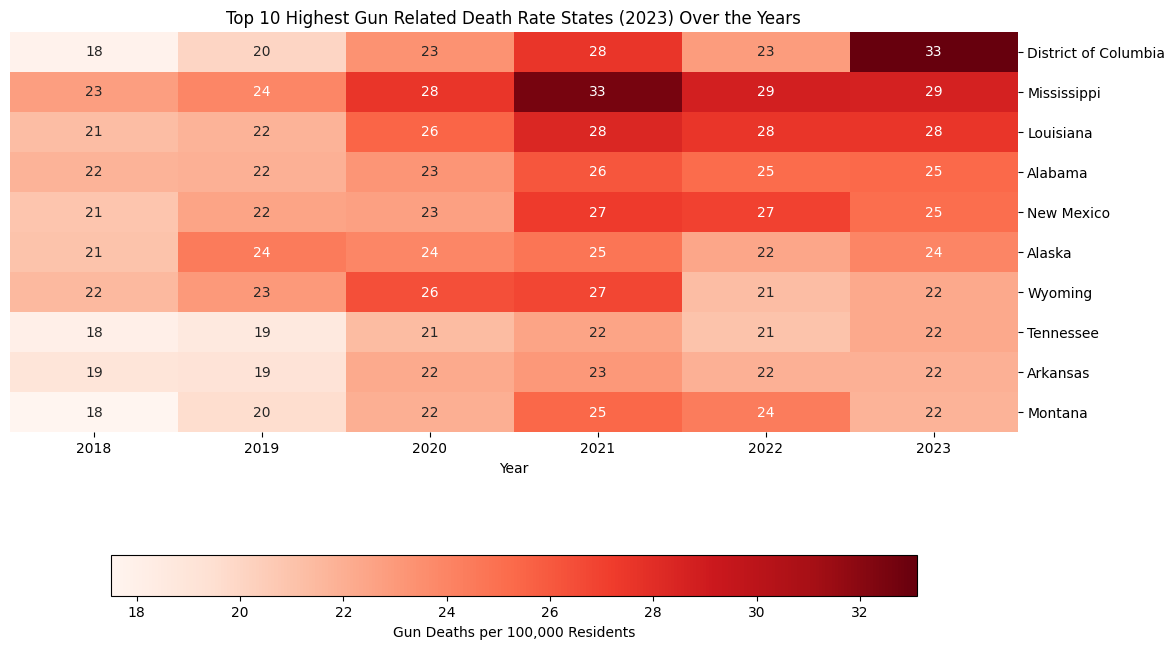

In [118]:
# Problem statement graph - why care about gun violence and laws?

# To filter down states, focus on the top 10 states for gun death rates in 2023
filtered_mortality_years_cleaned_2023 = mortality_years_cleaned[mortality_years_cleaned['Year'] == 2023]
sorted_filtered_mortality_years_cleaned = filtered_mortality_years_cleaned_2023.sort_values(by='Crude Rate', ascending=False)
sorted_filtered_mortality_years_cleaned_top_15 = sorted_filtered_mortality_years_cleaned.head(10)
top_states_2023 = sorted_filtered_mortality_years_cleaned_top_15['State'].tolist()

# Filter and prepare for heatmap
filtered_mortality_years_cleaned = mortality_years_cleaned[mortality_years_cleaned['State'].isin(top_states_2023)]
filtered_mortality_years_cleaned_heatmap = filtered_mortality_years_cleaned.pivot_table(index="State", columns="Year", values="Crude Rate")
filtered_mortality_years_cleaned_heatmap_sorted = filtered_mortality_years_cleaned_heatmap.reindex(top_states_2023) # have the correct order

# Want the eye to focus on recent data (darkest colors in heatmap), so move y axis to the right
fig, ax = plt.subplots(figsize=(13, 8))
heatmap = sns.heatmap(filtered_mortality_years_cleaned_heatmap_sorted, annot=True, cmap="Reds", ax=ax, cbar=False)


# Move the colorbar to the bottom of the graph - note got a lot of this code from online.
cbar = fig.colorbar(heatmap.collections[0], ax=ax, orientation='horizontal', shrink=0.8, pad=0.2)
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')
cbar.set_label('Gun Deaths per 100,000 Residents')

# Move y axis to the right and remove the title
ax.tick_params(right=True, labelright=True, left=False, labelleft=False, labelrotation='auto')
ax.set(ylabel=None)

ax.set_title("Top 10 Highest Gun Related Death Rate States (2023) Over the Years")

plt.show()


In [119]:
# Problem statement graph - why care about gun violence and laws?
# sns.barplot(children_and_teens_mortality, x="Value", y="Category", palette=['grey', 'grey', 'grey', 'grey', 'red'])

# plt.xlabel("Deaths in 2023")
# plt.ylabel("")
# plt.title("Causes of Death for Children and Teens (Ages 1-19) in 2023")
# sns.despine()

In [120]:
# Where is gun violence a problem in the US?

background = alt.Chart(states).mark_geoshape().encode(
    color=alt.Color('gun_deaths_per_100000_residents:Q',
                    title='Gun Deaths per 100,000 Residents',
                    scale=alt.Scale(scheme='reds'),)
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(df_final, 'id', ['gun_deaths_per_100000_residents'])
).project(
    type='albersUsa'
).properties(
    width=700,
    height=500

)

# Gun strength bubbles per states
points = alt.Chart(df_final, title='Gun Related Death Rates in the US (2023)').mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('gun_law_strength:Q').title('State Gun Law Strength (2025)'),
    color=alt.value('black'),
    tooltip=['state:N','gun_law_strength:Q']
)

outline = alt.Chart(states, title='Gun Related Death Rates in the US (2023)').mark_geoshape(stroke='black', fillOpacity=0).project(
    type='albersUsa'
).properties(
    width=700,
    height=500
)


final_chart = (background + outline).configure_legend(
        labelFontSize=10,
        titleFontSize=10
    )

final_chart

alt.LayerChart(...)

## Conclusion

In [121]:
# Conclusion - do stricter gun law states have lower gun related deaths?

final_chart_v2 = (background + points + outline).configure_legend(
        labelFontSize=10,
        titleFontSize=10
    )

final_chart_v2

alt.LayerChart(...)